In [1]:
%reset -f
import sys
sys.path.insert(0,'..')
import pandas as pd
import numpy as np
from wavhandler import *
from utils_train import *

data = Dataset('Wingbeats')
data.read(data='all', setting='read', labels='text', loadmat=False)

# data1 = Dataset('Leafminers')
# data1.read(data=data1.target_classes[0], setting='read', loadmat=False, labels='text')

# data2 = Dataset('LG')
# data2.read(data=data2.target_classes[0], setting='read', loadmat=False, labels='text')

# data3 = Dataset('LG')
# data3.read(data=data3.target_classes[1], setting='read', loadmat=False, labels='text')

# data4 = Dataset('Pcfruit')
# data4.read(data=data4.target_classes[1], setting='read', loadmat=False, labels='text')

# # data1.clean(plot=False)
# # data2.clean(plot=False)
# # data3.clean(plot=False)
# # data4.clean(plot=False)

# data = pd.DataFrame()
# data['filenames'] = pd.concat([data1.filenames, data2.filenames, data3.filenames, data4.filenames], axis=0).reset_index(drop=True)
# data['y'] = data.filenames.apply(lambda x: x.split('/')[6])

X, y = data.filenames.tolist(), data.y.tolist()
model_name='flies'
setting='stft'

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.
Using TensorFlow backend.


Data: all.
Read 279566 filenames in 0.79 seconds.


In [2]:
seed = 2018
np.random.seed(seed)
import soundfile as sf
from keras.applications.densenet import DenseNet121
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.layers import Input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

current_model = DenseNet121

y = LabelEncoder().fit_transform(y)
# X = X_names#np.array(X_names).reshape(-1,1)

X, y = shuffle(X, y, random_state=0) 

X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(X,y, random_state=0)

In [3]:
pd.Series(data.y.tolist()).value_counts()

Ae. aegypti            85553
C. quinquefasciatus    74599
An. gambiae            49471
C. pipiens             30415
Ae. albopictus         20231
An. arabiensis         19297
dtype: int64

In [4]:
pd.Series(y_test).value_counts()

0    8555
5    7460
3    4947
4    3042
1    2023
2    1930
dtype: int64

In [5]:
len(X_test)

27957

In [6]:
from keras.models import model_from_yaml
yaml_file = open('./temp_data/mosquitoes_spec.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml)

# load weights into new model
loaded_model.load_weights("./temp_data/mosquitoes_spec.h5")
print("Loaded model from disk")

loaded_model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

Loaded model from disk


In [7]:
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = -1#utils.find_layer_idx(loaded_model, 'preds')

# Swap softmax with linear
loaded_model.layers[layer_idx].activation = activations.linear
loaded_model = utils.apply_modifications(loaded_model)



(129, 120)


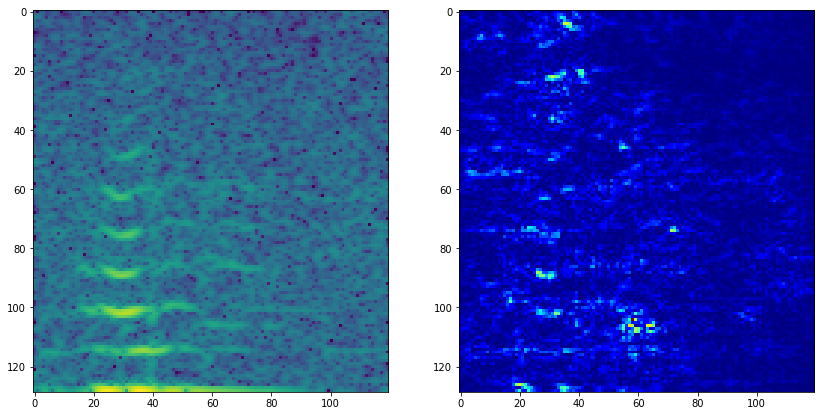

In [33]:
class_idx = 4
indices = np.where(y_test == class_idx)[0]

# pick some random input from here.
idx = indices[3]

obj = None
data, _ = librosa.load(X_test[idx], sr = SR)
data = metamorphose(data, setting=setting, stg_obj=obj)
data = np.expand_dims(data, axis = -1)
np.array(data, np.float32).shape

plt.figure(figsize=(14,10))
plt.subplot(1,2,1)
print(data[:,:,0].shape)
plt.imshow(data[:,:,0])


grads = visualize_saliency(loaded_model, layer_idx, filter_indices=class_idx, seed_input=np.array(data, np.float32))
# Plot with 'jet' colormap to visualize as a heatmap.
plt.subplot(1,2,2)
plt.imshow(grads, cmap='jet')

### CONFUSION MATRIX

In [5]:
y_pred = loaded_model.predict_generator(valid_generator(X_test, 
                                                    y_test, 
                                                    batch_size=32, 
                                                    setting=setting, 
                                                    target_names=data.y.unique().tolist()),
        steps = int(math.ceil(float(len(X_test)) / float(32))))

In [6]:
from sklearn.metrics import confusion_matrix,balanced_accuracy_score
x = confusion_matrix(np.array(y_test), np.argmax(y_pred, axis=1))
ac = balanced_accuracy_score(np.array(y_test), np.argmax(y_pred, axis=1))
ac

0.9264530011837673

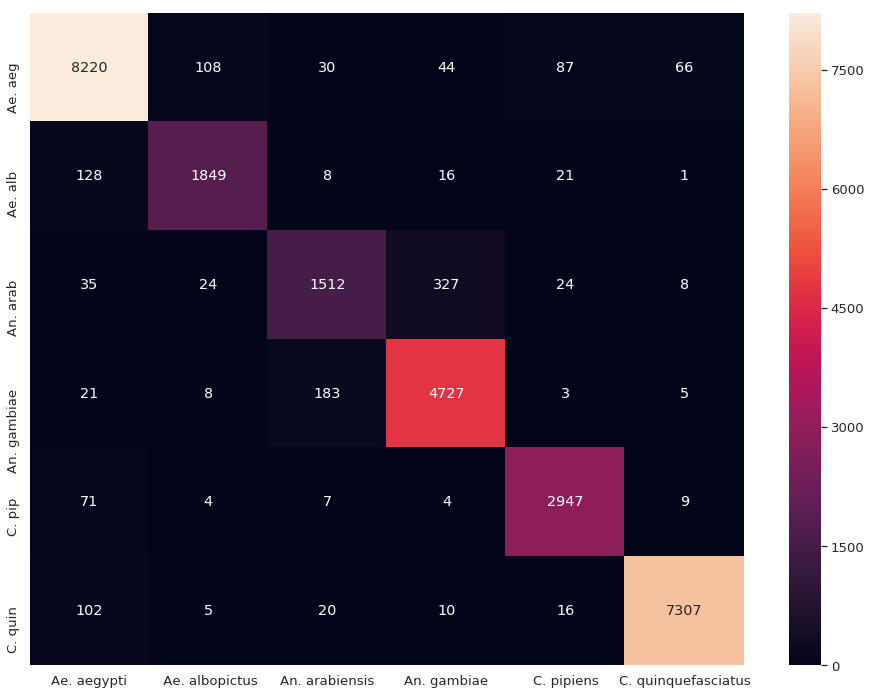

In [12]:
from sklearn.metrics import confusion_matrix
x = confusion_matrix(np.array(y_test), np.argmax(y_pred, axis=1))
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

plt.figure(figsize=(16,12))
sns.set(font_scale=1.2)
ticks = ['Ae. aegypti',' Ae. albopictus','An. arabiensis','An. gambiae','C. pipiens','C. quinquefasciatus']
ticks_short = ['Ae. aeg','Ae. alb','An. arab','An. gambiae','C. pip','C. quin']
sns.heatmap(x, annot=True, fmt='.0f', xticklabels=ticks, yticklabels=ticks_short)

In [11]:
from sklearn.metrics import accuracy_score

accuracy_score(np.array(y_test), np.argmax(y_pred, axis=1))

0.9501019422684838

In [ ]:
y_pred